In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st

1. Study Section 6.4.2 and reproduce Fig. 6.5 in Python.  Follow the same method we used in week 2 using 1000 intervals for $\theta$
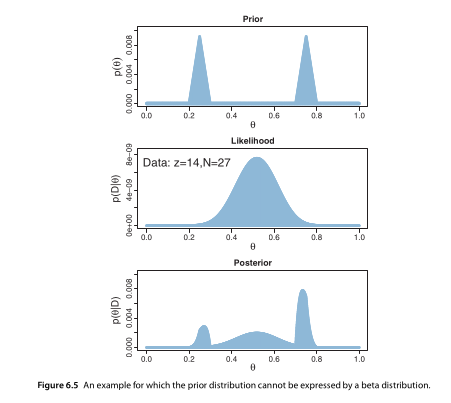

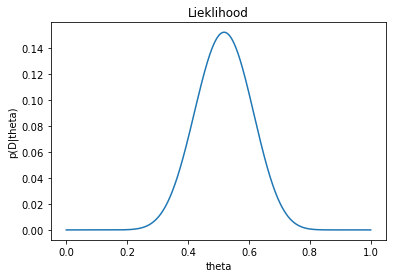

In [2]:
# Fine teeth for Theta.
theta = np.linspace(0.00000001, 1 - 0.00000001, num=1000)

def p_theta():
        # Two triangular peaks on a small non-zero floor
    p_theta = np.concatenate([np.repeat(1, 200), np.linspace(1, 100, num=50), np.linspace(100, 1, num=50), np.repeat(1, 200),
                              np.repeat(1, 200), np.linspace(1, 100, num=50), np.linspace(100, 1, num=50), np.repeat(1, 200)])
    # Make pTheta sum to 1.0
    return p_theta/sum(p_theta)
    
def p_d_given_theta():
    data = np.concatenate([np.repeat(0, 13), np.repeat(1, 14)])
    z = sum(data)
    N = len(data)
    return st.binom.pmf(k=z, n=N, p=theta)

def normalization_const(): 
    return np.sum(np.multiply(p_d_given_theta(), p_theta())) # numpy operations are faster than python (this will matter more for larger data sets)

def p_theta_given_d():
    denominator = np.sum(p_d_given_theta() * p_theta())
    return p_d_given_theta() * p_theta() / denominator 

def plot_prior():
    fig, ax = plt.subplots()
    ax.plot(theta, p_theta())

    ax.set(xlabel='theta', ylabel='p(theta)', title='Prior')
    plt.show()
    
    assert(abs(sum(p_theta()) - 1) < 0.001)

def plot_likelihood():
    fig, ax = plt.subplots()
    ax.plot(theta, p_d_given_theta())

    ax.set(xlabel='theta', ylabel='p(D|theta)', title='Lieklihood')
    plt.show()
    
def plot_posterior():    
    fig, ax = plt.subplots()
    ax.plot(theta, p_theta_given_d())

    ax.set(xlabel='theta', ylabel='p(theta|D)', title='Posterior')
    plt.show()
    
    assert(abs(sum(p_theta_given_d()) - 1) < 0.001)
    
plot_prior()
plot_likelihood()
plot_posterior()

2. Exercise 6.1 (make sure that you plot the intermediate posteriors, and compare the plots; you can reuse the plotting code from above, or make your own; or use any other way of plotting the beta density function given parameters, an online service, etc.)

**Exercise 6.1. [Purpose: For you to see the influence of the prior in each
successive flip, and for you to see another demonstration that the posterior
139140 Doing Bayesian Data Analysis
is invariant under re-orderings of the data.]*

For this exercise, use the R function
explained in Section 6.6 ( BernBeta.R ). (Don’t forget to source the function before
calling it.) Notice that the function returns the posterior beta values each time it is
called, so you can use the returned values as the prior values for the next function call.

In [3]:
# Fine teeth for Theta.
theta = np.linspace(0.00000000001, 1 - 0.00000000001, num=1000)

def beta(a,b):
    return st.beta.pdf(theta, a, b)

def likelihood(k, n):
    return st.binom.pmf(k=k, n=n, p=theta)

def posterior(prior, likelihood):
    return likelihood * prior / np.sum(likelihood * prior) 

def plot(prior, k, n):
    # prior
    fig, ax = plt.subplots()
    ax.plot(theta, prior)

    ax.set(xlabel='theta', ylabel='p(theta)', title='Prior')
    plt.show()

    # likelihood
    fig, ax = plt.subplots()
    ax.plot(theta, likelihood(k, n))

    ax.set(xlabel='theta', ylabel='p(D|theta)', title='Likelihood')
    plt.show()

    # posterior
    posterior_values = posterior(prior, likelihood(k, n))
    fig, ax = plt.subplots()
    ax.plot(theta, posterior_values)

    ax.set(xlabel='theta', ylabel='p(theta|D)', title='Posterior')
    
    def bounded_prob(bound):
        return sum([p for p in posterior_values if p > bound])
    bound = None
    for i in np.linspace(min(posterior_values), max(posterior_values), num=1000):
        if bound == None: bound = bounded_prob(i)
        if abs(bounded_prob(i) - 0.95) < abs(bounded_prob(bound) - 0.95):
            bound = i

    print("bound 95% = ", end="")
    print(bound)
    
    bounded_theta = [t for t,p in zip(theta, posterior_values) if p > bound]
    if len(bounded_theta) > 0:
        begin = bounded_theta[0]
        end = bounded_theta[-1]

        print("begin 95% = ", end="")
        print(begin)
        print("end 95% = ", end="")
        print(end)
        print("sum 95% = ", end="")
        print(sum([p for t, p in zip(theta, posterior_values) if t >= begin and t <= end]))
        low = min(posterior_values)
        high = max(posterior_values)
        def percentage(p):
            return low + (high - low) * p
        plt.hlines(percentage(0.025), begin, end, 'black', lw=1)
        plt.vlines(begin, percentage(0), percentage(0.05), 'black', lw=1)
        plt.vlines(end, percentage(0), percentage(0.05), 'black', lw=1)
        plt.text(begin, percentage(0.08), str(round(begin, 2)), horizontalalignment='center')
        plt.text(end, percentage(0.08), str(round(end, 2)), horizontalalignment='center')
    
    plt.show()
    
    assert(abs(sum(posterior_values) - 1) < 0.001)
    
    return posterior_values

(A) Start with a prior distribution that expresses some uncertainty that a coin is
fair: beta(θ|4, 4). Flip the coin once; suppose we get a head. What is the posterior
distribution?

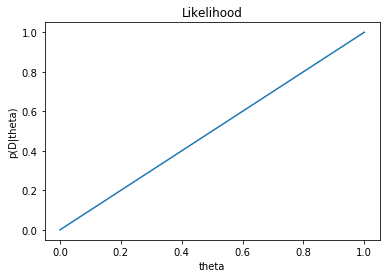

bound 95% = 0.0004803685263193373
begin 95% = 0.25425425425916914
end 95% = 0.8508508508438338
sum 95% = 0.9502384596125484


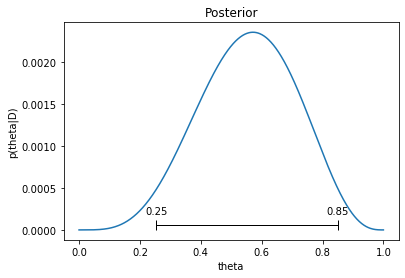

In [4]:
intermediate = plot(prior=beta(4,4), k=1, n=1)

(B) Use the posterior from the previous flip as the prior for the next flip. Suppose
we flip again and get a head. Now what is the new posterior? (Hint: If you type
post = BernBeta( c(4,4) , c(1) ) for the first part, then you can type post =
BernBeta( post , c(1) ) for the next part.)

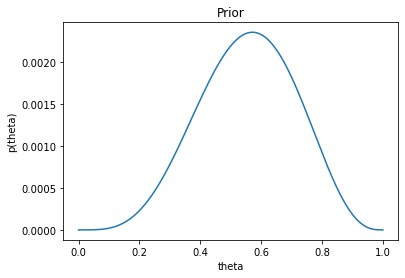

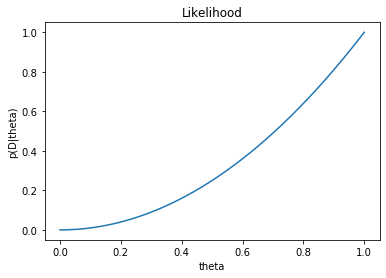

bound 95% = 0.0005199847321969263
begin 95% = 0.36736736737002
end 95% = 0.892892892885035
sum 95% = 0.9500571095340239


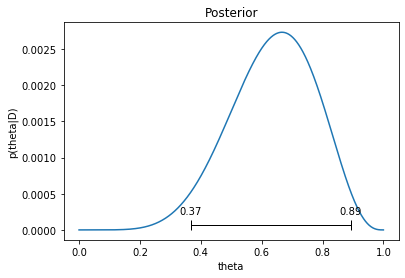

In [5]:
intermediate = plot(prior=intermediate, k=2, n=2)

(C) Using that posterior as the prior for the next flip, flip a third time and get a tail.
Now what is the new posterior? (Hint: Type post = BernBeta( post , c(0) ) .)

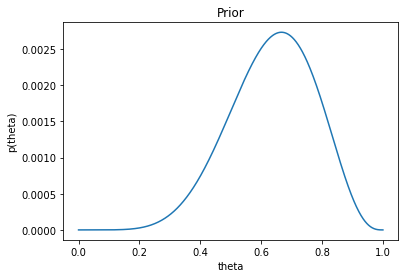

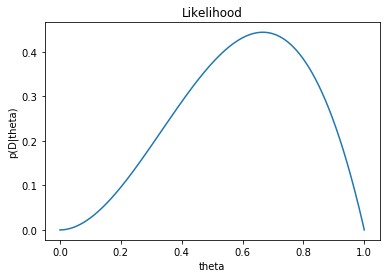

bound 95% = 0.0005559753212254914
begin 95% = 0.4014014014033734
end 95% = 0.8728728728654154
sum 95% = 0.9500505262839892


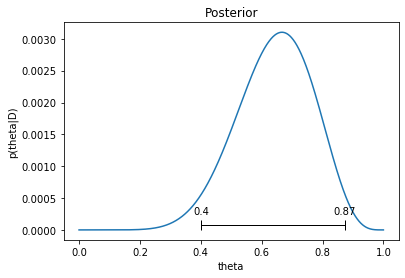

In [6]:
intermediate = plot(prior=intermediate, k=2, n=3)

(D) Do the same three updates but in the order T, H, H instead of H, H, T. Is the
final posterior distribution the same for both orderings of the flip results?

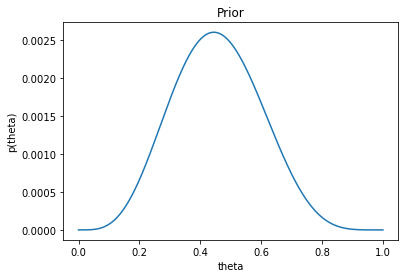

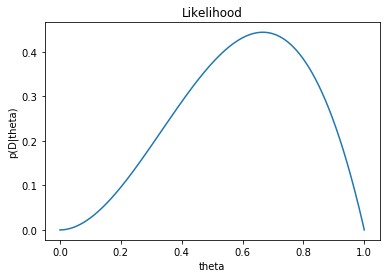

bound 95% = 0.0005348021888654807
begin 95% = 0.2522522522572072
end 95% = 0.7477477477427928
sum 95% = 0.9495660252211964


The final posterior is different, what gives?


In [7]:
intermediate = posterior(prior=beta(4,4), likelihood=likelihood(k=0, n=1))
intermediate = posterior(intermediate, likelihood(k=1, n=2))
intermediate = plot(intermediate, k=2, n=3)

print("The final posterior is different, what gives?")

3. Exercise 6.2 (you can plot HDP instead of HDI using pymc3.stats.hpd, or using posterior plots with credible_interval argument as we used in the last two weeks)

**Exercise 6.2. [Purpose: Connecting HDIs to the real world, with iterative data
collection.]**

Suppose an election is approaching, and you are interested in knowing
whether the general population prefers candidate A or candidate B. There is a just-
published poll in the newspaper, which states that of 100 randomly sampled people, 58
preferred candidate A and the remainder preferred candidate B.

(A) Suppose that before the newspaper poll, your prior belief was a uniform
distribution. What is the 95% HDI on your beliefs after learning of the newspaper poll
results?

In [8]:
def uniform():
    return [1/len(theta) for t in theta]

bound 95% = 0.0012156500943222611
begin 95% = 0.4834834834838138
end 95% = 0.6726726726692193
sum 95% = 0.9499072691480294


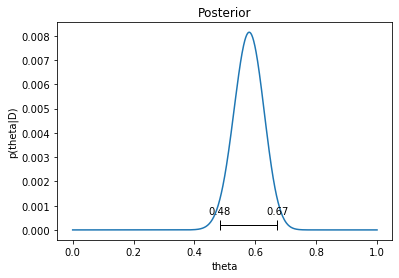

In [9]:
intermediate = plot(uniform(), k=58, n=100)

(B) You want to conduct a follow-up poll to narrow down your estimate of the
population’s preference. In your follow-up poll, you randomly sample 100 other people
and find that 57 prefer candidate A and the remainder prefer candidate B. Assuming
that peoples’ opinions have not changed between polls, what is the 95% HDI on the
posterior?

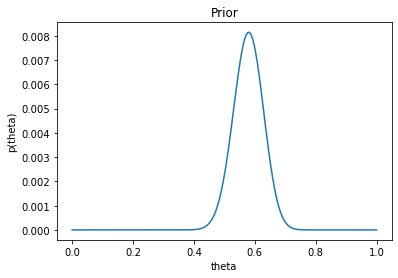

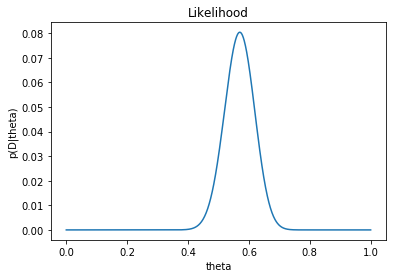

bound 95% = 0.0016527325045982942
begin 95% = 0.5065065065063764
end 95% = 0.6416416416388088
sum 95% = 0.9504512402579499


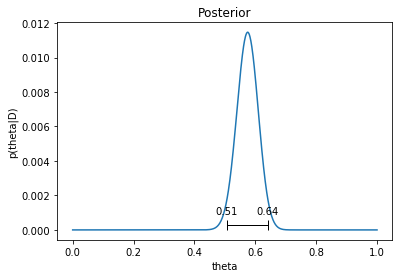

In [10]:
intermediate = plot(intermediate, k=57, n=100)

4. Exercise 6.3

**Exercise 6.3. [Purpose: Apply the Bayesian method to real data analysis. These
data are representative of real data (Kruschke, 2009).]**

Suppose you train people
in a simple learning experiment, as follows. When people see the two words, “radio” and
“ocean,” on the computer screen, they should press the F key on the computer keyboard.
They see several repetitions and learn the response well. Then you introduce another
correspondence for them to learn: Whenever the words “radio” and “mountain” appear,
they should press the J key on the computer keyboard. You keep training them until they
know both correspondences well. Now you probe what they’ve learned by asking them
about two novel test items. For the first test, you show them the word “radio” by itself
and instruct them to make the best response (F or J) based on what they learned before. Inferring a Binomial Probability via Exact Mathematical Analysis
For the second test, you show them the two words “ocean” and “mountain” and ask
them to make the best response.

You do this procedure with 50 people.
Your data show that for “radio” by itself, 40 people chose F and 10 chose J.
For the word combination “ocean” and “mountain,” 15 chose F and 35 chose J.
Are people biased toward F or toward J for either of the two probe types? To answer this question, assume a uniform prior, and use a 95% HDI to decide which biases can be declared to be credible. (Consult Chapter 12 for how to declare a parameter value to be not credible.)

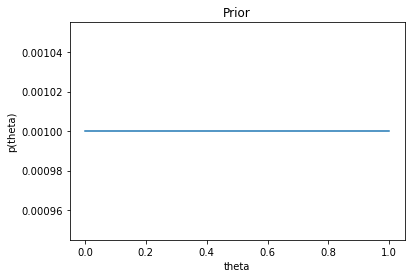

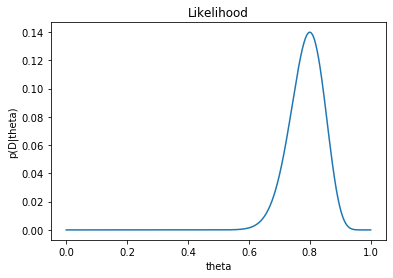

bound 95% = 0.0010788961324444814
begin 95% = 0.6776776776741241
end 95% = 0.892892892885035
sum 95% = 0.949924388816563


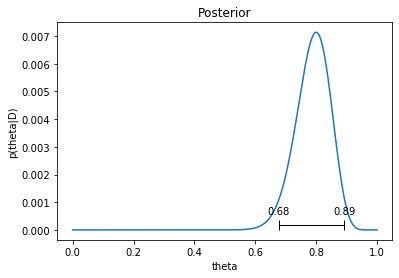

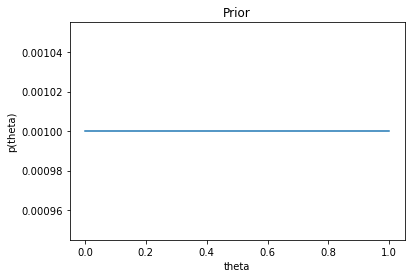

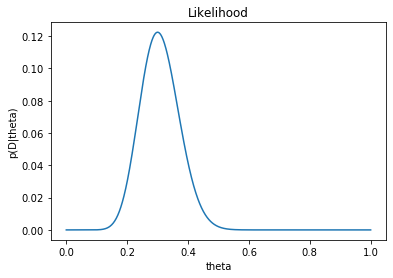

bound 95% = 0.0009565745101649271
begin 95% = 0.18718718719344343
end 95% = 0.43243243243378376
sum 95% = 0.9498463111031236


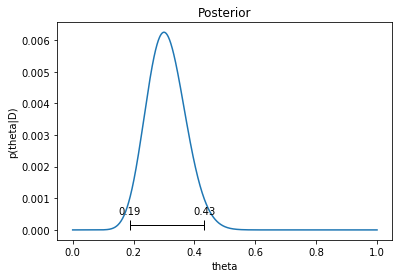

In [11]:
intermediate = plot(uniform(), k=40, n=50)
intermediate = plot(uniform(), k=15, n=50)

5. Exercise 6.4 + 6.5

**Exercise 6.4. [Purpose: To explore an unusual prior and learn about the beta
distribution in the process.]**

Suppose we have a coin that we know comes from a
magic-trick store, and therefore we believe that the coin is strongly biased either usually
to come up heads or usually to come up tails, but we don’t know which. Express this
belief as a beta prior. (Hint: See Figure 6.1, upper-left panel.) Now we flip the coin
5 times and it comes up heads in 4 of the 5 flips. What is the posterior distribution?
(Use the R function of Section 6.6 ( BernBeta.R ) to see graphs of the prior and
posterior.)

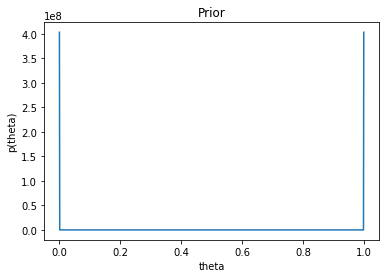

bound 95% = 0.0004360105115859284
begin 95% = 0.4634634634641942
end 95% = 0.998998998989019
sum 95% = 0.9498225122707691


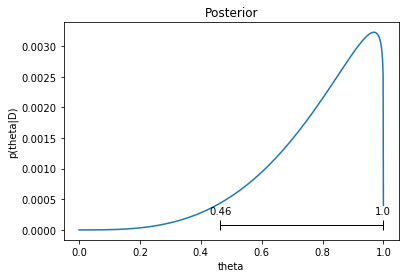

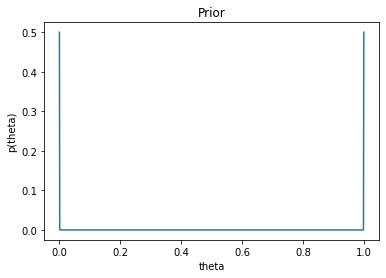

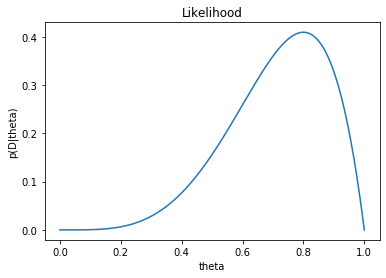

bound 95% = 0.0
begin 95% = 1e-11
end 95% = 0.99999999999
sum 95% = 1.0


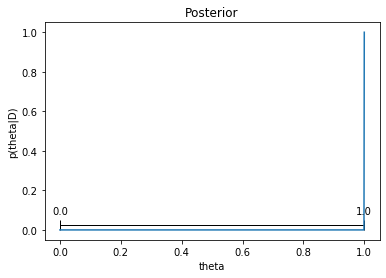

In [12]:
hard_pos = np.concatenate([[0.5], np.repeat(0, 998), [0.5]])
soft_pos = beta(a=0.1, b=0.1)
intermediate = plot(soft_pos, k=4, n=5)
intermediate = plot(hard_pos, k=4, n=5)

**Exercise 6.5. [Purpose: To get hands on experience with the goal of predicting
the next datum, and to see how the prior influences that prediction.]**


(A) Suppose you have a coin that you know is minted by the government and has
not been tampered with. Therefore you have a strong prior belief that the coin is fair.
You flip the coin 10 times and get 9 heads. What is your predicted probability of heads
for the 11th flip? Explain your answer carefully; justify your choice of prior.

If someone flipped a coin 10 times and got heads all ten times, I would probably be convinced that the government minted coin had a flaw or something


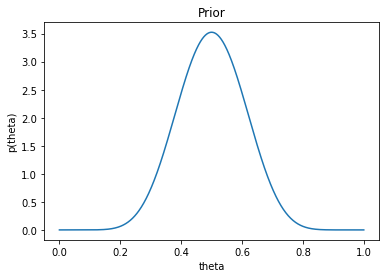

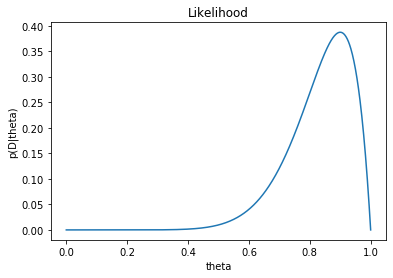

bound 95% = 0.0007288005012698634
begin 95% = 0.4634634634641942
end 95% = 0.7977977977918418
sum 95% = 0.9498095845923796


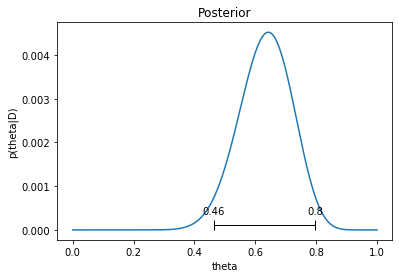

mode = 0.6426426426397898


In [22]:
print("If someone flipped a coin 10 times and got heads all ten times, I would probably be convinced that the government minted coin had a flaw or something")

intermediate = plot(beta(a=10, b=10), k=9, n=10)
print("mode = ", end="")
print([t for t, p in zip(theta, intermediate) if p == max(intermediate)][0])

(B) Now you have a different coin, this one made of some strange material and
marked (in fine print) “Patent Pending, International Magic, Inc.” You flip the coin 10
times and get 9 heads. What is your predicted probability of heads for the 11th flip?
Explain your answer carefully; justify your choice of prior. Hint: Use the prior from
Exercise 6.4.

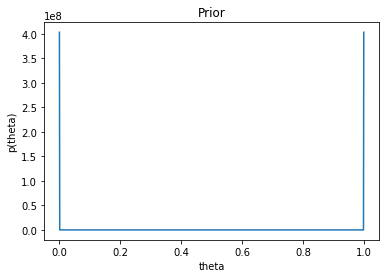

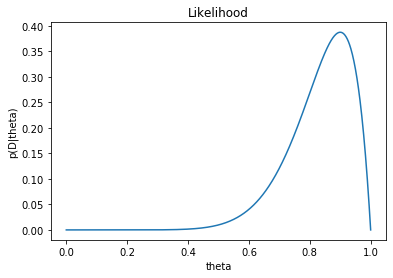

bound 95% = 0.0006385704168895741
begin 95% = 0.7067067067025726
end 95% = 0.99999999999
sum 95% = 0.9496929165825437


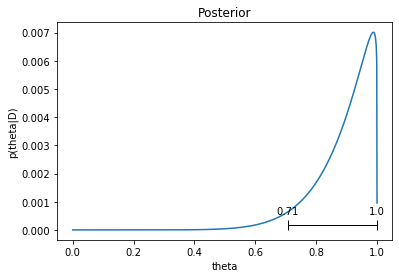

mode = 0.9879879879782282


In [24]:
intermediate = plot(beta(a=0.1, b=0.1), k=9, n=10)
print("mode = ", end="")
print([t for t, p in zip(theta, intermediate) if p == max(intermediate)][0])